In [2]:
# import soundfile as sf
# !pip install numpy
# !pip install librosa
# !pip install pandas
# !pip install matplotlib
# !pip install --upgrade setuptools
# !pip install dtw --user
# !py -m pip install --upgrade pip setuptools wheel
import numpy as np
import os
import librosa
import IPython.display as ipd
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#First loading both the user and the singer wav files

def audio_signal(path):
    audio, sr = librosa.load(path)
    return audio.astype(np.float32), sr
user_audio, sr1 = audio_signal('D:/Yash Mulik Study/Mini-Project/github_codespace/Song-Evaulation-System/wav/cover.wav')
og_audio, sr2 = audio_signal('D:/Yash Mulik Study/Mini-Project/github_codespace/Song-Evaulation-System/wav/og.wav')

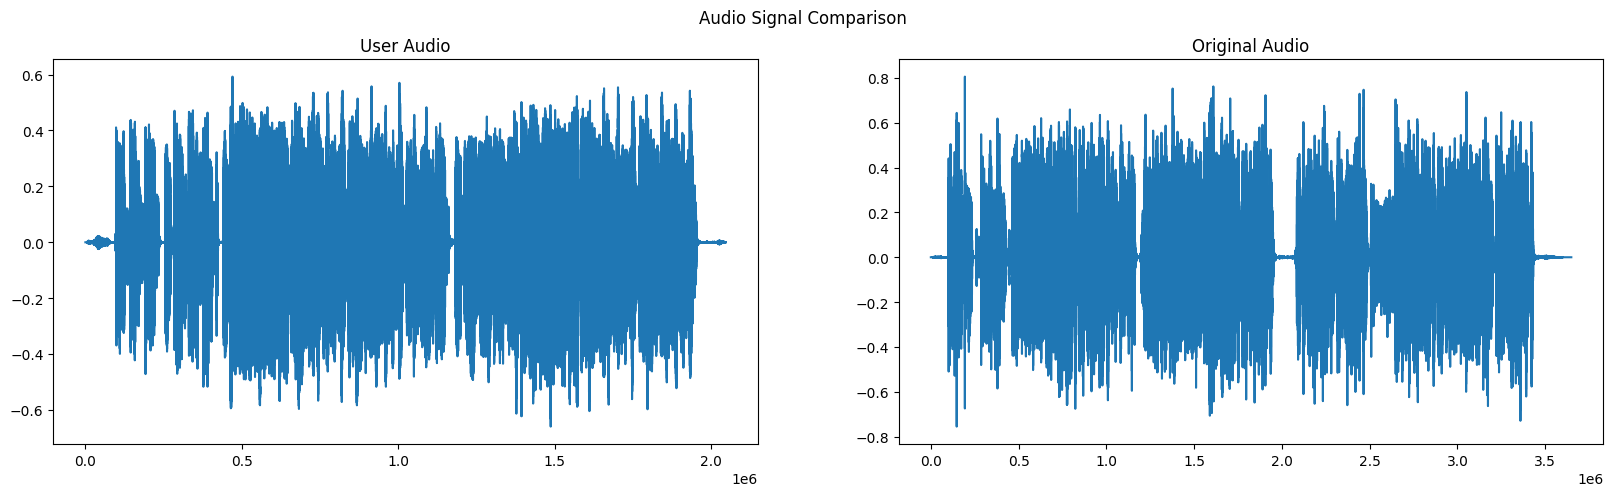

In [4]:
#Plotting thee audio signals
figure, ax = plt.subplots(1,2, figsize=(20,5))
figure.suptitle('Audio Signal Comparison')
ax[0].plot(user_audio)
ax[0].set_title('User Audio')
ax[1].plot(og_audio)
ax[1].set_title('Original Audio')
plt.show()

Since we are only working with the vocals of both the user and the original singer audio, we don't have a beat to synchronize the original and the user audio. Thus, we will use the MFCCs to align the audio 

Functions codecell : 

In [11]:
#Trimming the audios to the same length
def trim_audio(audio1, audio2):
    min_length = min(len(audio1), len(audio2))
    return audio1[:min_length], audio2[:min_length]

#Filling out the NaN values with the average of the previous and the next values
def fill_nan_with_avg(arr):
    mask = np.where(np.isnan(arr))[0]
    for i in mask:
        if i!=0 and i!=len(arr)-1:
            arr[i] = np.mean(arr[i-1], arr[i+1])
        elif i==0:
            arr[i] = arr[i+1]+0.0000001
        else:
            arr[i] = arr[i-1]+0.0000001
    return mask

# print(fill_nan_with_avg(user_audio))

#Extracting the fundamental frqeuency using librosa
def extract_f0(audio):
    f0, voiced_flag, voiced_probs = librosa.pyin(audio, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    f0 = fill_nan_with_avg(f0)
    return f0, voiced_flag, voiced_probs

#Detecting pitches
def detect_pitch(y, sr):
    pitches, magnitudes = librosa.core.piptrack(y=y, sr=sr, fmin=75, fmax=1600)
    # get indexes of the maximum value in each time slice
    max_indexes = np.argmax(magnitudes, axis=0)
    # get the pitches of the max indexes per time slice
    pitches = pitches[max_indexes, range(magnitudes.shape[1])]
    return pitches

#Using the librosa library to extract MFCCs
def extract_mfccs(audio, sr):
    mfccs = librosa.feature.mfcc(audio, sr=sr, n_mfcc=13)
    return mfccs

#DWT algorithm
def dtw(audio1, audio2):
    result = librosa.sequence.dtw(audio1.T, audio2.T, backtrack=True)
    return result[1]

#Aligning the audio signals
def align_audio(path):
    aligned_audio = []
    for frame in path:
        aligned_audio.append(user_audio[frame[0]])
    return np.array(aligned_audio)

def plot_signal(audio):
    plt.plot(audio)
    plt.show()

We will do the work in the following steps : 
* Our goal is to evaluate every aspect of the song individually and not with respect to one another
* For that, we will first divide the song into 32ms intervals.
* Then, we will apply the DTW on the amplitude vs time data in order to obtain the indices of the music instances most similar, which we will align.
* We will then a

In [ ]:
#Reference code snippets
import numpy as np

# Assuming 'data' is your speech signal array and 'fs' is the sampling frequency
frame_size = 0.32  # 320 ms
overlap = 0.5
frame_samples = int(frame_size * fs)
step_size = int(frame_samples * (1 - overlap))

# Function to compute the Lp norm
def lp_norm(data, p):
    return (np.sum(np.abs(data)**p))**(1/p)

# Compute the L6 norm over split-second intervals
l6_norms = []
for i in range(0, len(data) - frame_samples + 1, step_size):
    frame = data[i:i+frame_samples]
    l6_norm = lp_norm(frame, 6)
    l6_norms.append(l6_norm)

# Compute the L2 norm over all split-second L6 norms
l2_norm_over_l6 = lp_norm(np.array(l6_norms), 2)

print(f'L6 norms over split-second intervals: {l6_norms}')
print(f'L2 norm over all split-second L6 norms: {l2_norm_over_l6}')